# 1. Prepare Dataset

In [222]:
import requests
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from webdriver_manager.firefox import GeckoDriverManager
import pandas as pd
import re
import torch
from sklearn.metrics import mean_squared_error
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.translate.bleu_score import sentence_bleu
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from selenium import webdriver
from selenium.webdriver.common.by import By

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [223]:
def scrape_mayo_clinic_text(url):
    try:
        # Fetch the HTML content of the webpage
        response = requests.get(url)
        if response.status_code != 200:
            print(f"Failed to fetch the webpage. Status code: {response.status_code}")
            return None

        # Parse the HTML content using BeautifulSoup
        soup = BeautifulSoup(response.content, 'html.parser')

        # Find the div with class "mw-content-rtl mw-parser-output"
        content_div = soup.find("div", class_="mw-content-rtl mw-parser-output")
        if content_div:
            # Find all <p> tags within the content div
            paragraphs = content_div.find_all("p")

            # Store text from each <p> tag
            text_list = []
            for paragraph in paragraphs:
                text = paragraph.get_text(separator=' ').strip()
                if text:
                    text_list.append(text)

            return text_list
        else:
            print("Failed to find the content div.")
            return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [298]:
url1 = "https://ar.wikipedia.org/wiki/%D9%85%D8%B1%D8%B6_%D9%81%D9%8A%D8%B1%D9%88%D8%B3_%D9%83%D9%88%D8%B1%D9%88%D9%86%D8%A7_2019"
url2 = "https://ar.wikipedia.org/wiki/%D9%81%D9%8A%D8%B1%D9%88%D8%B3_%D9%83%D9%88%D8%B1%D9%88%D9%86%D8%A7_%D8%A7%D9%84%D9%85%D8%B1%D8%AA%D8%A8%D8%B7_%D8%A8%D8%A7%D9%84%D9%85%D8%AA%D9%84%D8%A7%D8%B2%D9%85%D8%A9_%D8%A7%D9%84%D8%AA%D9%86%D9%81%D8%B3%D9%8A%D8%A9_%D8%A7%D9%84%D8%AD%D8%A7%D8%AF%D8%A9_%D8%A7%D9%84%D8%B4%D8%AF%D9%8A%D8%AF%D8%A9_%D8%A7%D9%84%D9%86%D9%88%D8%B9_2"
url3 = "https://ar.wikipedia.org/wiki/%D9%81%D9%8A%D8%B1%D9%88%D8%B3_%D8%B1%D9%86%D8%A7_%D9%85%D9%81%D8%B1%D8%AF_%D8%A7%D9%84%D8%B3%D9%84%D8%B3%D9%84%D8%A9_%D9%85%D9%88%D8%AC%D8%A8_%D8%A7%D9%84%D8%A7%D8%AA%D8%AC%D8%A7%D9%87"
url4 = "https://ar.wikipedia.org/wiki/%D9%81%D9%8A%D8%B1%D9%88%D8%B3"
url5 = "https://ar.wikipedia.org/wiki/%D9%84%D9%82%D8%A7%D8%AD_%D9%83%D9%88%D9%81%D9%8A%D8%AF-19"

text1 = scrape_mayo_clinic_text(url1)
text2 = scrape_mayo_clinic_text(url2)
text3 = scrape_mayo_clinic_text(url3)
text4 = scrape_mayo_clinic_text(url4)
text5 = scrape_mayo_clinic_text(url5)

text = text1+text2+text3+text4+text5
len(text)

305

In [299]:
dataset = pd.DataFrame({"context": text})
dataset

,context
0,مرض فيروس كورونا 2019 ( بالإنجليزية : Corona...
1,تتضمن الأعراض الشائعة للمرض الحمى والسعال ...
2,ينتشر الفيروس في العادة بين الأشخاص أثناء الات...
3,تتضمن الإجراءات الهادفة إلى منع العدوى غسل ال...
4,يوجد الآن لقاح لفيروس كورونا أبرزها لقاح اوكسف...
...,...
300,حتى مع تطوير لقاحات جديدة خلال جائحة كوفيد-19،...
301,تسمح هذه العملية المستمرة لمجلس المنتجات الطبي...
302,في الولايات المتحدة، قد تمنح إدارة الغذاء والد...
303,تبقى الآثار الضارة المحتملة للقاح غير معروفة إ...


In [300]:
def clean_text(text):
  cleaned_text = re.sub(r'[^\w\s]|[\d]', '', text)
  return cleaned_text


dataset["context"] = dataset["context"].apply(clean_text)
dataset

,context
0,مرض فيروس كورونا بالإنجليزية Coronavirus ...
1,تتضمن الأعراض الشائعة للمرض الحمى والسعال ...
2,ينتشر الفيروس في العادة بين الأشخاص أثناء الات...
3,تتضمن الإجراءات الهادفة إلى منع العدوى غسل ال...
4,يوجد الآن لقاح لفيروس كورونا أبرزها لقاح اوكسف...
...,...
300,حتى مع تطوير لقاحات جديدة خلال جائحة كوفيد يتط...
301,تسمح هذه العملية المستمرة لمجلس المنتجات الطبي...
302,في الولايات المتحدة قد تمنح إدارة الغذاء والدو...
303,تبقى الآثار الضارة المحتملة للقاح غير معروفة إ...


In [301]:
stopwords_list = stopwords.words('arabic')
from functools import reduce

def remove_arabic_stopwords(text):
    # Tokenize the Arabic text
    tokens = word_tokenize(text)

    # Remove stopwords from the tokenized text
    filtered_tokens = [word for word in tokens if word not in stopwords_list and len(word)>1]
    return filtered_tokens

dataset["tokens"] = dataset["context"].apply(lambda x: remove_arabic_stopwords(x))

#dataset["score"] = np.random.randint(0, 11, size=len(dataset))
dataset["uniq"] = dataset["tokens"].apply(lambda x: set(x))

all_unique_words = reduce(set.union, dataset["uniq"])

def calculate_score(tokens, unique_words):
    return sum(1 for word in tokens if word in unique_words)



dataset["score"] = dataset["tokens"].apply(lambda x: calculate_score(x, all_unique_words))

# Normalize the raw scores to be between 0 and 10
max_raw_score = dataset["score"].max()
dataset["score"] = (dataset["score"] / max_raw_score) * 10
dataset

,context,tokens,uniq,score
0,مرض فيروس كورونا بالإنجليزية Coronavirus ...,"[مرض, فيروس, كورونا, بالإنجليزية, Coronavirus,...","{بالمتلازمة, أخرى, مليون, ولغاية, التنفسي, تم,...",5.000000
1,تتضمن الأعراض الشائعة للمرض الحمى والسعال ...,"[تتضمن, الأعراض, الشائعة, للمرض, الحمى, والسعا...","{أيام, الإرهاق, دموية, والمشكلات, للفيروس, الش...",6.055556
2,ينتشر الفيروس في العادة بين الأشخاص أثناء الات...,"[ينتشر, الفيروس, العادة, الأشخاص, أثناء, الاتص...","{لأولئك, قطرات, الوجه, أيام, للعدوى, مأخوذة, ا...",8.055556
3,تتضمن الإجراءات الهادفة إلى منع العدوى غسل ال...,"[تتضمن, الإجراءات, الهادفة, منع, العدوى, غسل, ...","{الوجه, تماما, الجائحة, للفيروس, أفضل, إزالة, ...",5.888889
4,يوجد الآن لقاح لفيروس كورونا أبرزها لقاح اوكسف...,"[يوجد, لقاح, لفيروس, كورونا, أبرزها, لقاح, اوك...","{واسترازينيكا, فايزربيونتك, كورونا, اوكسفورد, ...",0.611111
...,...,...,...,...
300,حتى مع تطوير لقاحات جديدة خلال جائحة كوفيد يتط...,"[تطوير, لقاحات, جديدة, خلال, جائحة, كوفيد, يتط...","{ملف, كامل, نهاية, عملية, تقديم, لقاحات, تجارب...",2.500000
301,تسمح هذه العملية المستمرة لمجلس المنتجات الطبي...,"[تسمح, العملية, المستمرة, لمجلس, المنتجات, الط...","{فترة, السريرية, تسمح, الفعلي, مرشح, لقاح, الم...",1.388889
302,في الولايات المتحدة قد تمنح إدارة الغذاء والدو...,"[الولايات, المتحدة, تمنح, إدارة, الغذاء, والدو...","{سلامته, إساءة, كامل, سكان, للقاحات, المعادية,...",2.111111
303,تبقى الآثار الضارة المحتملة للقاح غير معروفة إ...,"[تبقى, الآثار, الضارة, المحتملة, للقاح, معروفة...","{الصحة, المصنعة, نطاق, مراقبة, الرابعة, لتنفيذ...",2.833333


In [302]:
from torch.nn.utils.rnn import pad_sequence

tokens = dataset["context"].tolist()
word_to_index = {}
index = 0
for sentence in tokens:
    for word in sentence:
        if word not in word_to_index:
            word_to_index[word] = index
            index += 1

# Convert tokens to sequences of integer indices
sequences = [[word_to_index[word] for word in sentence] for sentence in tokens]

# Convert sequences to PyTorch tensor and pad them
padded_tokens = pad_sequence([torch.tensor(seq) for seq in sequences], batch_first=True, padding_value=0)
print(padded_tokens.shape)

torch.Size([305, 1511])


In [303]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded_tokens, torch.tensor(dataset["score"]), test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Add a dimension for the sequence length
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

<ipython-input-303-8aa687aa0091>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Add a dimension for the sequence length
<ipython-input-303-8aa687aa0091>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
<ipython-input-303-8aa687aa0091>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
<ipython-input-303-8aa687aa0091>:8: UserWarning: To copy co

In [304]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)


# 1 . Definning and traiing RNN

In [305]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)  # Initial hidden state
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # Take the last output of the sequence
        return out

In [306]:
# Parameters
input_size = X_train.shape[2]  # Assuming each input is a single feature
hidden_size = 128  # Number of units in the hidden layer
output_size = 1  # Single output for regression
batch_size = 128
num_epochs = 50

In [315]:
# Initialize the model
model = SimpleRNN(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

loss_train_RNN = []
evaluation_losses_RNN = []  # List to store evaluation loss
rmse_eval_RNN = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    # Calculate training loss
    epoch_loss = running_loss / len(train_loader.dataset)
    loss_train_RNN.append(epoch_loss)

    # Evaluate on the test set
    model.eval()
    eval_loss = 0.0
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            eval_loss += loss.item() * inputs.size(0)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(labels.cpu().numpy())

    # Calculate and store evaluation loss
    avg_eval_loss = eval_loss / len(test_loader.dataset)
    evaluation_losses_RNN.append(avg_eval_loss)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    rmse_eval_RNN.append(rmse)

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Evaluation Loss: {avg_eval_loss:.4f}, RMSE: {rmse:.4f}, BLEU Score: {bleu_score:.4f}")

Epoch [1/50], Training Loss: 8.6103, Evaluation Loss: 5.2628, RMSE: 2.2941, BLEU Score: 0.0000
Epoch [2/50], Training Loss: 4.2279, Evaluation Loss: 2.6856, RMSE: 1.6388, BLEU Score: 0.0000
Epoch [3/50], Training Loss: 3.1032, Evaluation Loss: 4.3874, RMSE: 2.0946, BLEU Score: 0.0000
Epoch [4/50], Training Loss: 4.1580, Evaluation Loss: 3.9989, RMSE: 1.9997, BLEU Score: 0.0000
Epoch [5/50], Training Loss: 3.4125, Evaluation Loss: 2.6554, RMSE: 1.6295, BLEU Score: 0.0000
Epoch [6/50], Training Loss: 2.3289, Evaluation Loss: 2.3053, RMSE: 1.5183, BLEU Score: 0.0000
Epoch [7/50], Training Loss: 2.2163, Evaluation Loss: 2.7054, RMSE: 1.6448, BLEU Score: 0.0000
Epoch [8/50], Training Loss: 2.4521, Evaluation Loss: 2.4912, RMSE: 1.5784, BLEU Score: 0.0000
Epoch [9/50], Training Loss: 2.0882, Evaluation Loss: 1.7294, RMSE: 1.3151, BLEU Score: 0.0000
Epoch [10/50], Training Loss: 1.4832, Evaluation Loss: 1.2922, RMSE: 1.1367, BLEU Score: 0.0000
Epoch [11/50], Training Loss: 1.2680, Evaluation 

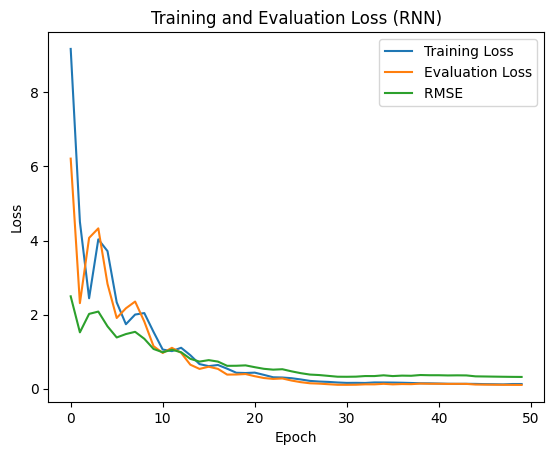

In [308]:
import matplotlib.pyplot as plt

plt.plot(loss_train_RNN, label="Training Loss")
plt.plot(evaluation_losses_RNN, label="Evaluation Loss")
plt.plot(rmse_eval_RNN, label="RMSE ")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss (RNN)")
plt.legend()
plt.show()


# 2. Defining and Training GRU

In [309]:
class SimpleGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleGRU, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)  # Initial hidden state
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])  # Take the last output of the sequence
        return out

In [310]:
# Initialize the model
model = SimpleGRU(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Define data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

loss_train_GRU = []
evaluation_losses_GRU = []  # List to store evaluation loss
rmse_eval_GRU = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    # Calculate training loss
    epoch_loss = running_loss / len(train_loader.dataset)
    loss_train_GRU.append(epoch_loss)

    # Evaluate on the test set
    model.eval()
    eval_loss = 0.0
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            eval_loss += loss.item() * inputs.size(0)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(labels.cpu().numpy())

    # Calculate and store evaluation loss
    avg_eval_loss = eval_loss / len(test_loader.dataset)
    evaluation_losses_GRU.append(avg_eval_loss)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    rmse_eval_GRU.append(rmse)


    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Evaluation Loss: {avg_eval_loss:.4f}, RMSE: {rmse:.4f}, BLEU Score: {bleu_score:.4f}")

Epoch [1/50], Training Loss: 6.9647, Evaluation Loss: 2.2808, RMSE: 1.5102, BLEU Score: 0.0000
Epoch [2/50], Training Loss: 1.9284, Evaluation Loss: 1.3621, RMSE: 1.1671, BLEU Score: 0.0000
Epoch [3/50], Training Loss: 1.1808, Evaluation Loss: 0.8600, RMSE: 0.9273, BLEU Score: 0.0000
Epoch [4/50], Training Loss: 0.7824, Evaluation Loss: 0.5617, RMSE: 0.7495, BLEU Score: 0.0000
Epoch [5/50], Training Loss: 0.5549, Evaluation Loss: 0.3863, RMSE: 0.6215, BLEU Score: 0.0000
Epoch [6/50], Training Loss: 0.4440, Evaluation Loss: 0.3020, RMSE: 0.5496, BLEU Score: 0.0000
Epoch [7/50], Training Loss: 0.3680, Evaluation Loss: 0.2266, RMSE: 0.4760, BLEU Score: 0.0000
Epoch [8/50], Training Loss: 0.3087, Evaluation Loss: 0.1806, RMSE: 0.4249, BLEU Score: 0.0000
Epoch [9/50], Training Loss: 0.2541, Evaluation Loss: 0.1509, RMSE: 0.3885, BLEU Score: 0.0000
Epoch [10/50], Training Loss: 0.1914, Evaluation Loss: 0.1297, RMSE: 0.3601, BLEU Score: 0.0000
Epoch [11/50], Training Loss: 0.1687, Evaluation 

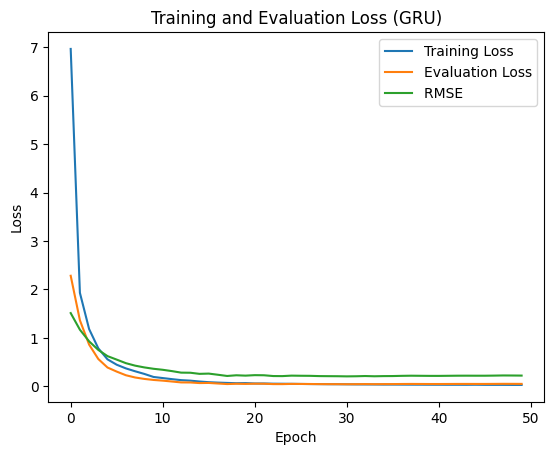

In [311]:
import matplotlib.pyplot as plt

plt.plot(loss_train_GRU, label="Training Loss")
plt.plot(evaluation_losses_GRU, label="Evaluation Loss")
plt.plot(rmse_eval_GRU, label="RMSE ")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss (GRU)")
plt.legend()
plt.show()


# 3. Defining and Training LSTM

In [312]:
import torch
import torch.nn as nn

class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)  # Initial hidden state
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)  # Initial cell state
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take the last output of the sequence
        return out


In [317]:
# Initialize the model
model = SimpleLSTM(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Define data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

loss_train_LSTM = []
evaluation_losses_LSTM = []  # List to store evaluation loss
rmse_eval_LSTM = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    # Calculate training loss
    epoch_loss = running_loss / len(train_loader.dataset)
    loss_train_LSTM.append(epoch_loss)

    # Evaluate on the test set
    model.eval()
    eval_loss = 0.0
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            eval_loss += loss.item() * inputs.size(0)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(labels.cpu().numpy())

    # Calculate and store evaluation loss
    avg_eval_loss = eval_loss / len(test_loader.dataset)
    evaluation_losses_LSTM.append(avg_eval_loss)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    rmse_eval_LSTM.append(rmse)

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Evaluation Loss: {avg_eval_loss:.4f}, RMSE: {rmse:.4f}, BLEU Score: {bleu_score:.4f}")

Epoch [1/50], Training Loss: 8.3244, Evaluation Loss: 3.5660, RMSE: 1.8884, BLEU Score: 0.0000
Epoch [2/50], Training Loss: 3.1008, Evaluation Loss: 2.3297, RMSE: 1.5264, BLEU Score: 0.0000
Epoch [3/50], Training Loss: 2.0077, Evaluation Loss: 1.6317, RMSE: 1.2774, BLEU Score: 0.0000
Epoch [4/50], Training Loss: 1.4480, Evaluation Loss: 1.1042, RMSE: 1.0508, BLEU Score: 0.0000
Epoch [5/50], Training Loss: 0.9693, Evaluation Loss: 0.7317, RMSE: 0.8554, BLEU Score: 0.0000
Epoch [6/50], Training Loss: 0.6768, Evaluation Loss: 0.5115, RMSE: 0.7152, BLEU Score: 0.0000
Epoch [7/50], Training Loss: 0.4888, Evaluation Loss: 0.3465, RMSE: 0.5886, BLEU Score: 0.0000
Epoch [8/50], Training Loss: 0.3767, Evaluation Loss: 0.3027, RMSE: 0.5502, BLEU Score: 0.0000
Epoch [9/50], Training Loss: 0.3530, Evaluation Loss: 0.2680, RMSE: 0.5177, BLEU Score: 0.0000
Epoch [10/50], Training Loss: 0.3079, Evaluation Loss: 0.2205, RMSE: 0.4695, BLEU Score: 0.0000
Epoch [11/50], Training Loss: 0.2743, Evaluation 

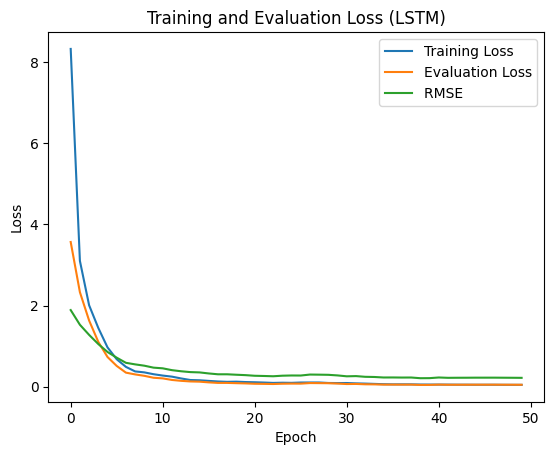

In [318]:
import matplotlib.pyplot as plt

plt.plot(loss_train_LSTM, label="Training Loss")
plt.plot(evaluation_losses_LSTM, label="Evaluation Loss")
plt.plot(rmse_eval_LSTM, label="RMSE ")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss (LSTM)")
plt.legend()
plt.show()